# Deducing the concentration of PM2.5 based on AOD and weather, etc. with Machine Learning Models

> Note: This notebook is under development. <br> Author: Weiye Chen (weiyechen@zju.edu.cn)
<br> Collaborating with Keran Sun, Qingjie Yang, Anzhou Li.

## 0. Importing Libraries

In [1]:
from osgeo import gdal

In [2]:
from scipy import stats

In [3]:
import sklearn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
import math
import scipy as sp
from scipy.stats import randint as sp_randint

In [6]:
import csv

In [7]:
# Render matplotlib graph as SVG
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
import warnings; warnings.simplefilter('ignore')

## 1. Importing Data
### 1.1 Raster Image I/O
Define the function which loads/writes image grid data with file name specified.

Empowered by GDAL library. Code credited to Andrain Lee (Anzhou Li).

* `Grid.read_img(path2file)`
    * This function convert image grid data to python supported data structures.
    * Returns:
        * A numpy array representing the values in the grid in respect to the original data and shape
        * A projection configuration that's included in the image grid
        * A configuration on geometric transformation.
* `Grid.write_img(_file, img_data, img_proj, img_geotrans, _format)`
    * This function converts python based image data structures to GIS raster formatted files.
    * Input parameters includes:
        * `_file`: path to file where the image is exported to.
        * `img_data`: numpy array representing the grid values.
        * `img_projection`: projection configuration.
        * `img_geotrans`: gemetric transformation configuration.
        * `_format`: string, could be either `"GTiff"` or `"HFA"`
    

In [9]:
class Grid(object):
    @staticmethod
    def read_img(_file):
        dataset = gdal.Open(_file)
        # 数据描述
        # print(dataset.GetDescription())

        # 图像的列数X与行数Y
        img_width = dataset.RasterXSize
        img_height = dataset.RasterYSize

        # 仿射矩阵
        img_geotrans = dataset.GetGeoTransform()

        # 投影
        img_proj = dataset.GetProjection()

        # 将数据写成数组，对应栅格矩阵
        img_data = dataset.ReadAsArray(0, 0, img_width, img_height)

        # 数据格式大小
        # print(img_data.shape)

        del dataset
        return img_data, img_proj, img_geotrans

    @staticmethod
    def write_img(_file, img_data, img_proj, img_geotrans, _format):
        # 判断栅格数据的数据类型
        if 'int8' in img_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in img_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32

        # 判读数组维数
        if len(img_data.shape) == 3:
            img_bands, img_height, img_width = img_data.shape
        else:
            img_bands, (img_height, img_width) = 1, img_data.shape

        # 创建文件
        # HFA -> .img | GTiff -> .tif
        if _format == 'tif':
            driver = gdal.GetDriverByName("GTiff")
        else:
            driver = gdal.GetDriverByName("HFA")

        dataset = driver.Create(_file, img_width, img_height, img_bands, datatype)

        # 写入仿射变换参数
        dataset.SetGeoTransform(img_geotrans)
        # 写入投影
        dataset.SetProjection(img_proj)
        # 写入数组数据
        # GetRasterBand()
        if img_bands == 1:
            dataset.GetRasterBand(1).WriteArray(img_data)
        else:
            for i in range(img_bands):
                dataset.GetRasterBand(i + 1).WriteArray(img_data[i])

        del dataset

Specifying the extent: our research extent.

In [10]:
x_min = -1225790
x_max = 53952
y_min = -639572
y_max = 685124

### 1.2 Loading Samples

#### 1.2.1 Loading Samples from table
Our weather data and PM2.5 ground truth are point based attribute data and we have them stored as a comma-delimited table file. We would transform the sample tables into python data structures.
* `loadSample`
    * Input parameters:
        * `date`: the date where the data is in.
        * `hour`: the hour where the data is in.
    * Returns:
        * `x`: a numpy matrix where each row represents values from an attribute.
        * `xt_np`: a numpy matrix where each column represents values from an attribute.
        * `y_np`: a numpy array representing data of target variable.

In [13]:
def loadSample(date, hour):       
    with open('./table/data-'+ str(date) + "-" + str(hour) + '.csv', newline='') as csvfile:
        x_aod = []
        x_at = []
        x_dem = []
        x_rh = []
        x_pr = []
        x_ndvi = []
        x_ws = []
        y = []
        ones = []
        table = csv.DictReader(csvfile, delimiter=',', quotechar='|')
        for row in table:
            ones.append(1.0)
            x_aod.append(float(row['AOD']))
            x_at.append(float(row['AirTemp']))
            x_dem.append(float(row['DEM']))
            x_rh.append(float(row['RH']))
            x_pr.append(float(row['SeaLevelPr']))
            x_ndvi.append(float(row['NDVI']))
            x_ws.append(float(row['WindSpeed']))
            y.append(float(row['pm2_5']))
        xt = [np.array(ones),
              x_ndvi, 
              x_dem, 
              x_aod, 
              x_at, 
              x_rh, 
              x_pr, 
              x_ws]
        xt_np = np.mat(xt)
        x = np.transpose(xt_np)
        y_np = np.transpose(np.mat(y))
#         print(np.shape(x))
#         print(x)
#         print(xt_np)
#         print(y_np)
        return x, xt_np, y_np

#### 1.2.2 Test for coefficient of correlation between target and variables in samples

Using pearson-r metric to measure the degrees of correlation between targets and variables.

In [11]:
from scipy.stats.stats import pearsonr

In [12]:
def ComputePearsonR():
    fileList = ['14-1', '14-4', '14-7', '15-1', '15-7', '16-1', '16-4', '16-7']
    for file in fileList:
        with open('./table/data-'+ file + '.csv', newline='') as csvfile:
            x_aod = []
            x_at = []
            x_dem = []
            x_rh = []
            x_pr = []
            y = []
            table = csv.DictReader(csvfile, delimiter=',', quotechar='|')
            for row in table:
                x_aod.append(float(row['AOD']))
                x_at.append(float(row['AirTemp']))
                x_dem.append(float(row['DEM']))
                x_rh.append(float(row['RH']))
                x_pr.append(float(row['SeaLevelPr']))
                y.append(float(row['pm2_5']))
            r1 = pearsonr(x_aod, y)
            r2 = pearsonr(x_at, y)
            r3 = pearsonr(x_dem, y)
            r4 = pearsonr(x_rh, y)
            r5 = pearsonr(x_pr, y)
            print(file, r1[1] < 0.05, r2[1] < 0.05, r3[1] < 0.05, r4[1] < 0.05, r5[1] < 0.05)

ComputePearsonR()

14-1 True True True False False
14-4 False True True True True
14-7 True True True True True
15-1 False True True True False
15-7 True True True True True
16-1 True True True False True
16-4 True True True True False
16-7 True True True True True


### 1.3 Performing Multivariate Linear Regression

In [14]:
class MLR:     
    def __init__(self, x, y = None):
        
        self.init()
        if (y is None):
            self.x = np.array(matrix[:,0:-1])
            self.y = np.array(matrix[:,-1])
            shape = np.shape(matrix)
            self.k = shape[1] - 2
            self.n = shape[0]
        else:
            self.x = x
            self.y = y
            self.k = np.shape(x)[1] - 1
            self.n = np.shape(x)[0]
    
    def init(self):
        self.r2 = 0.
        self.t = []
        self.p_t = []
        self.f = 0.
        self.p_f = 0.
        self.ess = 0.
        self.rss = 0.
        self.tss = 0.
        self.r2_adj = 0.

        
    def OLS(self):
        x = self.x
        y = self.y
        x_t = np.transpose(x)
        xt_x_inv = np.matmul(x_t, x)
        xt_x_inv = np.linalg.inv(xt_x_inv)
        beta = np.matmul(xt_x_inv, x_t)
        beta = np.matmul(beta, y)
        self.beta = beta
        y_e = self.PredictionE(x)
        deviation1 = self.y - y_e
        print(deviation1)
        deviation = deviation1 ** 2
        self.rss = np.sum(deviation)
        mean = np.mean(y)
        self.tss = np.sum((y-mean) * (y-mean))
        self.ess = self.tss - self.rss
        self.f = (self.ess / self.k) / (self.rss / (self.n - self.k - 1))
        self.r2 = 1 - self.rss / self.tss
        self.r2_adj = 1 - (self.rss / (self.n - self.k - 1)) / (self.tss / (self.n - 1))
        self.p_f = 1 - stats.f.cdf(self.f, self.k, (self.n - self.k - 1))
        sigma2 = self.rss / (self.n - self.k - 1)
        beta_array = np.array(np.transpose(beta)[0])
        cii = []
        for i in range(0, self.k + 1):
            cii.append(xt_x_inv[i][i])
        cii_np = np.array(cii)
        self.t = beta_array / np.sqrt(cii_np * sigma2)
        self.p_t = 1 - stats.t.cdf(np.absolute(self.t), self.n - self.k - 1)
        
    def PredictionE(self, x):
        return np.matmul(x, self.beta)

### 1.4 Import Image Data

In [15]:
img_templete, proj_templete, geotrans_templete = Grid.read_img("./img_data/dem.tif")
line_num, row_num = img_templete.shape

In [16]:
img_intercept = img_templete.copy()
img_aod = img_templete.copy()
img_t = img_templete.copy()
img_p = img_templete.copy()
img_ws = img_templete.copy()
img_rh = img_templete.copy()
img_dem = img_templete.copy()
img_ndvi = img_templete.copy()

In [17]:
DEM = img_templete
NDVI, proj, trans = Grid.read_img("./img_data/ndvi.tif")
imageDictTemplate = {
    'Intercept': img_intercept,
    'AOD': img_aod,
    'T': img_t,
    'P': img_p,
    'WS': img_ws,
    'RH': img_rh
}

We need to get the image data and read them as a linear array and output the tuple representing the shape of the oringinal image data.
* `readImageDataAsArray`
    * A encapsulated function that reads image data as a linear array
    * Input parameter: `filePath` path to the image file
    * Returns:
        * `array`: the linear data array
        * `shape`: the integer tuple representing the shape of the original image data.

In [18]:
def readImageDataAsArray(filePath):
    data = Grid.read_img(filePath)[0]
    shape = np.shape(data)
    array = data.ravel()
#     print("Original Shape: \t" + str(shape))
#     print("Flattened array size: \t" + str(np.shape(array)[0]))
#     print("Array:\t" + str(array))
    return array, shape

In [19]:
ndviArray, shape = readImageDataAsArray("./img_data/ndvi.tif")
demArray = readImageDataAsArray("./img_data/dem.tif")[0]

For each timestamp that we would study, we have multiple independent variables related. We have to load them as an array.

In [20]:
def dict2Mat(date, hour):
    matrix = np.mat([
        ndviArray.astype("float32").ravel(), 
        demArray.astype("float32").ravel(), 
        readImageDataAsArray("./img_data/aod-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/t-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/rh-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/p-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/ws-" + str(date) + "-" + str(hour) + ".tif")[0]
    ])
    return matrix

## 2. Regression Using Machine Learning

### 2.1 Preprocessing the sample data

In [40]:
x141, xt141, y141 = loadSample(14,1)

In [146]:
def plotSamples(xt, y, date, hour):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    fig.suptitle("Scatter Plot of Samples Table (Observed PM2.5 Concentration - Dependent Variables) - Mar " 
                 + str(date) + " " + str(hour+8) + ":00 UTC+8", fontweight="heavy")
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    variablesName = ["Constant(1)","NDVI", "DEM", "AOD", "Surface Temperature", "Relative Humidity", "Sea Level Pressure", " Wind Speed"]
    y = np.asarray(y).ravel()
    
    for i in range(0,8):
        x = np.asarray(xt[i,:]).ravel()
        ax[int(i/4), int(i%4)].set_xlabel(variablesName[i])
        ax[int(i/4), int(i%4)].set_ylabel("PM 2.5 (µg/m^3)")
        ax[int(i/4), int(i%4)].plot(x, y, 'b,')
        x_new = np.linspace(x.min(), x.max(), 5)
        coefs = np.polynomial.polynomial.polyfit(x, y, 1)
        ffit = np.polynomial.polynomial.polyval(x_new, coefs)
        ax[int(i/4), int(i%4)].plot(x_new, ffit)

    
    fig.show()

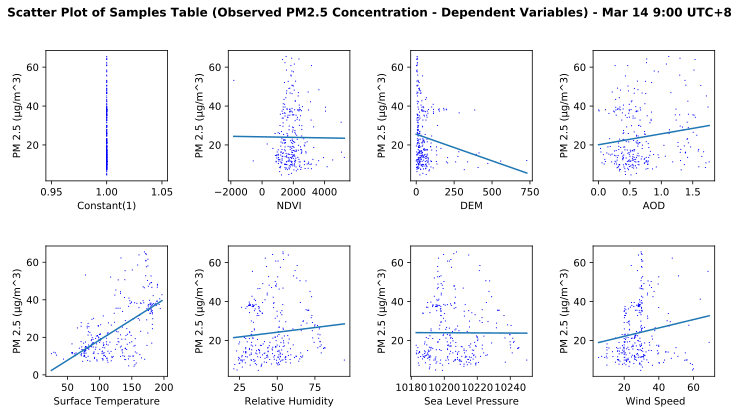

In [147]:
plotSamples(xt141, y141, 14,1)

Divide sample data into two sets with randomness, one for training and one for testing.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Before we move on to the machine learning model, we should normalize the data. It's very important as to improve the performance of the machine learning models.

In [22]:
def getStdSample(sample):
    std = np.array(np.std(sample, axis = 0))[0]
#     print("Standard deviation:")
#     print(std)
    return std

In [23]:
def getMeanSample(sample):
    mean = np.array(np.mean(sample, axis = 0))[0]
#     print("Mean:")
#     print(mean)
    return mean

Data will be normalized with a mean of 0 and a standard deviation of 1.

In [24]:
def normalize(sample):
    matrix = preprocessing.scale(sample)
#     print("Normalized Sample Matrix")
#     print(matrix)
    return matrix, getMeanSample(sample), getStdSample(sample)

In [25]:
def DivideData(matrix, ratioTesting):
    x = np.array(matrix[:,0:-1])
    y = np.array(np.transpose(matrix[:,-1]))
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=ratioTesting)
    return xtrain, xtest, ytrain, ytest

### 2.2 Preprocessing image data

Normalize the image data with the mean and std-dev from the samples.

In [26]:
def normalizeImg(matrix, mean, std):
    matrix = np.transpose(matrix)
    meanMat = np.ones(np.shape(matrix))
    stdMat = np.ones(np.shape(matrix))
    meanMat = meanMat * mean
    stdMat = stdMat * std
    matrix = (matrix - meanMat) / stdMat
    return matrix

### 2.3 Parameter Tuning, Cross Validation and Training Regression Models
We would like to build machine learning models (SVR, MLP, Random Forest). As we build the model, parameter tuning is required to get the best parameter set so that we could produce the result with best accuracy. To do the parameter tuning, we need to use `GridSearchCV` or `RandomizedSearchCV` which combines both optimal parameter search and cross validation.
<br>
* **Cross Validation**: 
    * Cross-validation, sometimes called rotation estimation, or out-of-sample testing is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. In a prediction problem, a model is usually given a dataset of known data on which training is run (training dataset), and a dataset of unknown data (or first seen data) against which the model is tested (called the validation dataset or testing set). The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).
    
    * k-fold cross-validation with validation and test set 
        * In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. 
        * The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.

<br>

* **Parameter Tuning**: (Credit: [Sci-Kit Learn](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator))

    * Hyper-parameters are parameters that are not directly learnt within estimators. It is possible and recommended to search the hyper-parameter space for the best cross validation score. 
    * Two generic approaches to sampling search candidates are provided in scikit-learn: 
        1. For given values, `GridSearchCV` exhaustively considers all parameter combinations. 
        2. `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution. 

#### 2.3.1 Parameter Search + Load Cross Validation Library
Parameters should be tuned before applied to prediction processes. [Sci-Kit Learn Doc](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* **Grid Search CV**
    * Grid Search CV: https://scikit-learn.org/stable/modules/genxerated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
    * Search within given parameter combinations to get the best cross validation score.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

* Printing function of the Parameter Search + Cross Validation results.

In [28]:
def printBestParameterInfo(regr, modelName=None):
    print("------ " + modelName + " ------")
    print("Best parameters set found on development set:")
#     print()
    print(regr.best_params_)
    print()
#     print("Grid scores on development set:")
#     print()
#     means = regr.cv_results_['mean_test_score']
#     stds = regr.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, regr.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print()

#### 2.3.2 Supporting Vector Machine Regression
Doc on SVM: https://scikit-learn.org/stable/modules/svm.html#svm-regression
<br>
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [29]:
from sklearn.svm import SVR

In [30]:
def SVMR(xtrain, ytrain):
    param_dist = {
        "kernel": ['rbf', 'poly', 'sigmoid'],
        "C": [1, 10, 100, 1000],
        "gamma": [0.001, 0.0001],
        "epsilon": [0.1, 0.3, 0.5]
    }
    regr = GridSearchCV(SVR(), param_dist, cv=4)
#     regr = SVR(gamma='scale', C=1.0, epsilon=0.2)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "SVR")
    return regr

#### 2.3.3 Multilayer Perceptron
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [31]:
from sklearn.neural_network import MLPRegressor

In [32]:
def multiLayerPerceptron(xtrain, ytrain):
    param_dist = [{
        "solver": ['lbfgs'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001]
    },{
        "solver": ['adam'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001],
        "learning_rate_init": [0.001, 0.01]
    },{
        "solver": ['sgd'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001],
        "learning_rate": ['constant', 'invscaling', 'adaptive'],
        "learning_rate_init": [0.001, 0.01],
        "momentum": [0.7, 0.8, 0.9]
    }]
    regr = GridSearchCV(MLPRegressor(), param_dist, cv=4)
#     regr = MLPRegressor(solver='lbfgs', activation = 'logistic', alpha=1e-6, hidden_layer_sizes=(5, 5), random_state=1)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "MLP")
    return regr

#### 2.3.4 Random Forest Regressor
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
def randomForest(xtrain, ytrain):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)]
    # Number of features to consider at every split
#     max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 3]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    param_dist = {'n_estimators': n_estimators,
#                    'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    regr = GridSearchCV(RandomForestRegressor(), param_dist, cv=3)
#     regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "Random Forests")
    
    return regr

### 2.4 Prediction

In [35]:
def denormalizeImg(matrix, mean, std):
    matrix = matrix * std + mean
    return matrix

## 3. Put things altogether

### 3.1 Serialized Deduction Procedure

1. Load samples
2. Normalize samples and divide data into sets randomly
3. Train the ML models with cross-validation
4. Load Image data and normalize them using the scale in samples
5. Predict PM2.5 concentration and save the map
6. Display and export ML regression model thumbnails

In [ ]:
from sklearn.metrics import mean_squared_error

In [36]:
def PM25ConcentrationDeduction(date, hour):
    print("###########################################################")
    print("-----------------------------------------------------------")
    print("###########################################################")
    print("Running PM 2.5 Deduction Program on " + str(date) + "-" + str(hour) + " (date-hour).")
    #### Getting Samples Ready ####
    # import sample table
    x, xt, y = loadSample(date, hour)
    # normalize sample
    norm = normalize(np.column_stack((x, y))[:, 1:]) # returns normalized sample table, mean, standard deviation
    # partition samples
    xtr, xte, ytr, yte = DivideData(norm[0], 0.2)
    
    #### Train Models using Samples ####
    svm = SVMR(xtr, ytr)
    print("SVM Model Score: ")
    print("r^2: " + str(svm.score(xte, yte)))
    svm_pred = svm.predict(xte)
    print("MSE: " + str(mean_squared_error(yte, svm_pred)))
    print()
    mlp = multiLayerPerceptron(xtr, ytr)
    print("MLP Model Score: ")
    print("+ r^2: "+ str(mlp.score(xte, yte)))
    mlp_pred = mlp.predict(xte)
    print("+ MSE: " + str(mean_squared_error(yte, mlp_pred)))
    print()
    rf = randomForest(xtr, ytr)
    print("Random Forests Model Score: ")
    print("+ r^2: "+ str(rf.score(xte, yte)))
    rf_pred = rf.predict(xte)
    print("+ MSE: " + str(mean_squared_error(yte, rf_pred)))
    
    #### Predicting on the field data ####
    # read all variables matrix related to this time
    matrix = dict2Mat(date, hour)
    normImg = normalizeImg(matrix, norm[1][0:-1], norm[2][0:-1])
    pred_svm = np.reshape(svm.predict(normImg), shape)
    pred_svm = denormalizeImg(pred_svm, norm[1][-1], norm[2][-1])
    pred_mlp = np.reshape(mlp.predict(normImg), shape)
    pred_mlp = denormalizeImg(pred_mlp, norm[1][-1], norm[2][-1])
    pred_rf = np.reshape(rf.predict(normImg), shape)
    pred_rf = denormalizeImg(pred_rf, norm[1][-1], norm[2][-1])
    Grid.write_img("./svm-" + str(date) + "-" + str(hour) + ".tif", pred_svm, proj_templete, geotrans_templete, "GTiff")
    Grid.write_img("./mlp-" + str(date) + "-" + str(hour) + ".tif", pred_mlp, proj_templete, geotrans_templete, "GTiff")
    Grid.write_img("./rf-" + str(date) + "-" + str(hour) + ".tif", pred_rf, proj_templete, geotrans_templete, "GTiff")
    
    print("Task of Running PM 2.5 Deduction Program on " + str(date) + "-" + str(hour) + " (date-hour) is finished.")
    print()

In [37]:
def showDeducedPM25(date, hour):
    print("Here are the deduced PM2.5 concentration maps on Mar. " + str(date) + " " + str(hour) + ":00 based on Machine Learning Models")
    svm = Grid.read_img("./svm-" + str(date) + "-" + str(hour) + ".tif")[0]
    mlp = Grid.read_img("./mlp-" + str(date) + "-" + str(hour) + ".tif")[0]
    rf = Grid.read_img("./rf-" + str(date) + "-" + str(hour) + ".tif")[0]

    a = np.array([0,7, 12, 16, 20, 23, 26, 30.5, 35.5, 55.5,150.5,500])
    norm = matplotlib.colors.BoundaryNorm(a, 256)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
    fig.suptitle("Mar. " + str(date) + " " + str(hour+8) + ":00, 2019: PM2.5 Concentration Deduced using Machine Learning", fontsize=18)
    fig.subplots_adjust(wspace = 0.05)
    # plt.subplot(131)
    ax[0].title.set_text("Supporting Vector Machine")
    im = ax[0].imshow(svm, cmap="RdYlGn_r", norm=norm)
    # plt.subplot(132)
    ax[1].title.set_text("Multilayer Perceptron")
    ax[1].imshow(mlp, cmap="RdYlGn_r", norm=norm)
    # plt.subplot(133)
    ax[2].title.set_text("Random Forest")
    ax[2].imshow(rf, cmap="RdYlGn_r", norm=norm)

    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.82)
    
    fig.savefig("./ml-" + str(date) + "-" + str(hour) + "_thumb.png", dpi=200)

In [38]:
PM25ConcentrationDeduction(14,1)
PM25ConcentrationDeduction(14,4)
PM25ConcentrationDeduction(14,7)
PM25ConcentrationDeduction(15,1)
PM25ConcentrationDeduction(15,4)
PM25ConcentrationDeduction(15,7)
PM25ConcentrationDeduction(16,1)
PM25ConcentrationDeduction(16,4)
PM25ConcentrationDeduction(16,7)


###########################################################
-----------------------------------------------------------
###########################################################
Running PM 2.5 Deduction Program on 14-1 (date-hour).
------ SVR ------
Best parameters set found on development set:
{'C': 1000, 'epsilon': 0.3, 'gamma': 0.001, 'kernel': 'rbf'}


SVM Model Score: 0.5793405625435487

------ MLP ------
Best parameters set found on development set:
{'activation': 'tanh', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam'}


MLP Model Score: 0.8070370628381771

------ Random Forests ------
Best parameters set found on development set:
{'bootstrap': True, 'max_depth': 85, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Random Forests Model Score: 0.6759954391747145

Task of Running PM 2.5 Deduction Program on 14-1 (date-hour) is finished.

###########################################################
-----------------------------------------------

Here are the deduced PM2.5 concentration maps on Mar. 14 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 14 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 14 7:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 7:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 7:00 based on Machine Learning Models


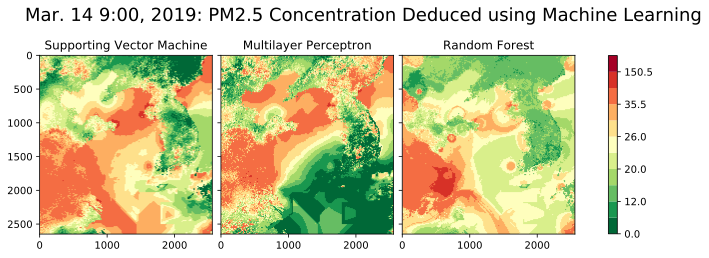

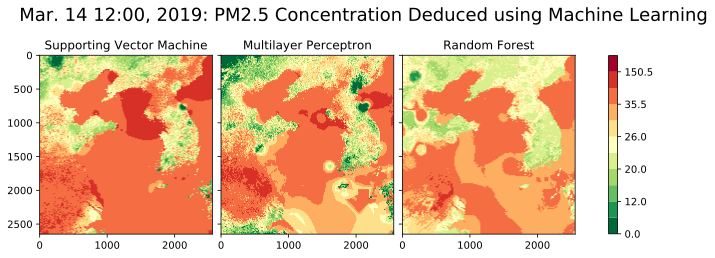

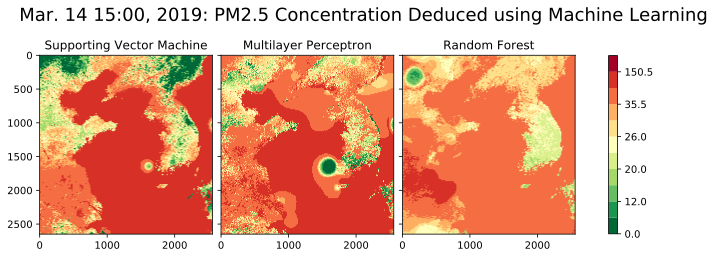

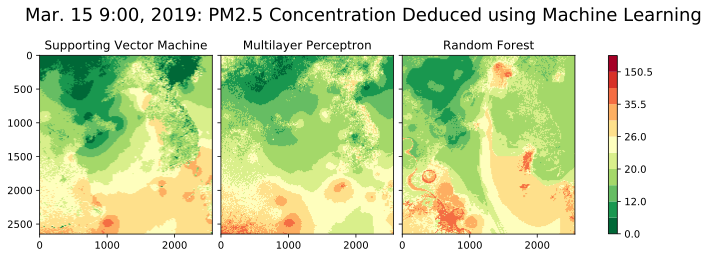

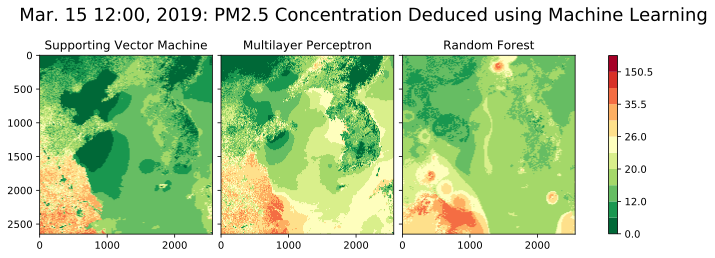

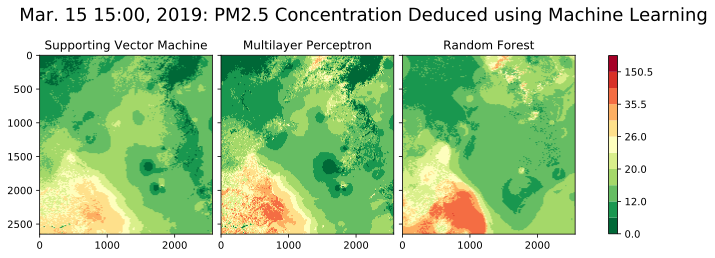

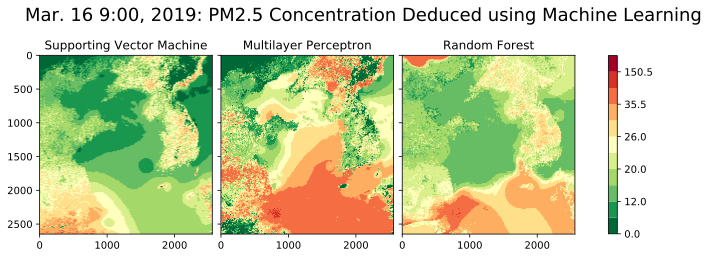

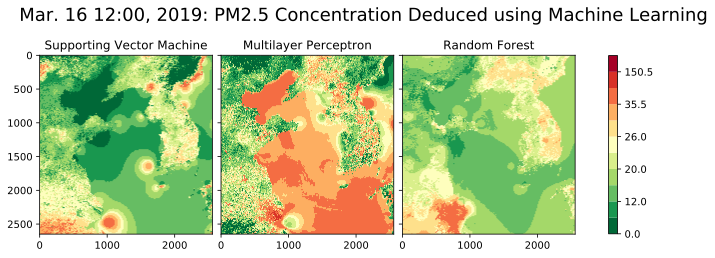

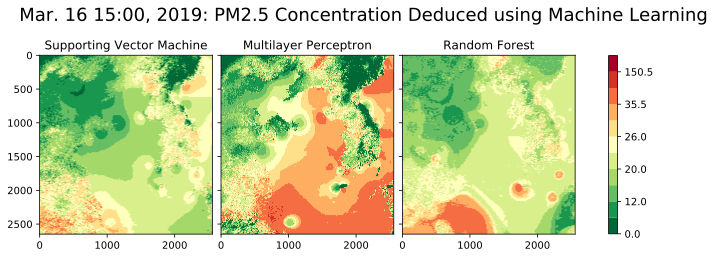

In [39]:
showDeducedPM25(14,1)
showDeducedPM25(14,4)
showDeducedPM25(14,7)
showDeducedPM25(15,1)
showDeducedPM25(15,4)
showDeducedPM25(15,7)
showDeducedPM25(16,1)
showDeducedPM25(16,4)
showDeducedPM25(16,7)